In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# MNIST DATASET

In [1]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time

2025-04-20 02:15:03.283550: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745115303.479144      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745115303.538379      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [144]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

In [145]:
def preprocess_images(images):
  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
  return np.where(images > .5, 1.0, 0.0).astype('float32')

train_images_clean = preprocess_images(train_images)
test_images = preprocess_images(test_images)

In [146]:
def add_gaussian_noise(images, mean=0, stddev= 0.05):
    noisy_images = images + np.random.normal(mean, stddev, images.shape)
    return np.clip(noisy_images, 0, 1)  # Keep pixel values in valid range

train_images_noisy = add_gaussian_noise(train_images_clean.copy())


def add_random_outliers(images, fraction=0.05):
    num_pixels = int(fraction * images.size)
    idxs = np.random.choice(images.size, num_pixels, replace=False)
    images.flat[idxs] = np.random.choice([0.0, 1.0], size=num_pixels)  # Flip randomly to max/min intensity
    return images

train_images = add_random_outliers(train_images_noisy.copy())

In [147]:
TRAIN_SIZE = 60000
BATCH_SIZE = 32
TEST_SIZE = 10000

train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(TRAIN_SIZE).batch(BATCH_SIZE))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(TEST_SIZE).batch(BATCH_SIZE))

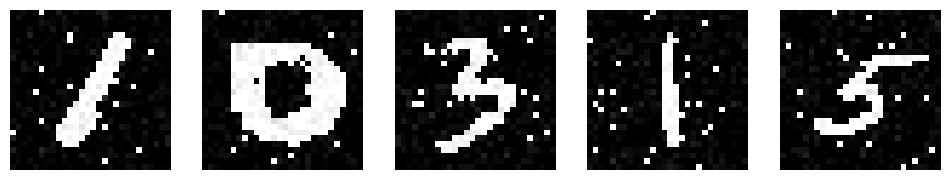

In [148]:
import matplotlib.pyplot as plt

# Grab a batch of images from train_dataset
for batch in train_dataset.take(1):  # Take only one batch for visualization
    sample_images = batch.numpy()[:5]  # Convert Tensor to NumPy and select first 5 images

# Plot the images
fig, axes = plt.subplots(1, 5, figsize=(12, 3))
for i in range(5):
    axes[i].imshow(sample_images[i], cmap='gray')  # Use grayscale for MNIST
    axes[i].axis('off')
plt.show()

# Train Gaussian and Student T VAE

In [156]:
tfd = tfp.distributions
class CVAE(tf.keras.Model):
    """Convolutional Variational Autoencoder with both Gaussian and Student's t-distributions."""

    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim

        # Shared Encoder
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(2 * latent_dim + 3 * latent_dim)  # Gaussian: mean+logvar, Student's t: df+mean+scale
        ])

        # Shared Decoder
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7 * 7 * 32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same')
        ])

    def encode(self, x):
        params = self.encoder(x)
        mean, logvar = tf.split(params[:, :2 * self.latent_dim], num_or_size_splits=2, axis=1)
        df, mean_t, scale_t = tf.split(params[:, 2 * self.latent_dim:], num_or_size_splits=3, axis=1)
        df = tf.nn.softplus(df) + 2  # Ensure df is positive (>2 to avoid instability)
        scale_t = tf.nn.softplus(scale_t)  # Ensure scale is positive
        return mean, logvar, df, mean_t, scale_t

    def reparameterize_gaussian(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * 0.5) + mean

    def reparameterize_student_t(self, df, mean, scale):
        chi2_samples = tfd.Chi2(df).sample()
        eps = tf.random.normal(shape=mean.shape)
        return mean + scale * eps / tf.sqrt(chi2_samples / df)

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            return tf.sigmoid(logits)
        return logits

optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(-0.5 * ((sample - mean) ** 2 * tf.exp(-logvar) + logvar + log2pi), axis=raxis)

def log_student_t_pdf(sample, df, mean, scale, raxis=1):
  t_dist = tfd.StudentT(df=df, loc=mean, scale=scale)
  return tf.reduce_sum(t_dist.log_prob(sample), axis=raxis)

def compute_loss(model, x):
  x = tf.cast(x, tf.float32)
  mean, logvar, df, mean_t, scale_t = model.encode(x)

  # Sample from both Gaussian and Student's t
  z_gaussian = model.reparameterize_gaussian(mean, logvar)
  z_student_t = model.reparameterize_student_t(df, mean_t, scale_t)

  # Decode both samples
  x_logit_gaussian = model.decode(z_gaussian)
  x_logit_student_t = model.decode(z_student_t)

  # Compute loss for Gaussian latent space
  cross_ent_gaussian = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit_gaussian, labels=x)
  logpx_z_gaussian = -tf.reduce_sum(cross_ent_gaussian, axis=[1, 2, 3])
  logpz_gaussian = log_normal_pdf(z_gaussian, 0., 0.)
  logqz_x_gaussian = log_normal_pdf(z_gaussian, mean, logvar)

  # Compute loss for Student’s t latent space
  cross_ent_student_t = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit_student_t, labels=x)
  logpx_z_student_t = -tf.reduce_sum(cross_ent_student_t, axis=[1, 2, 3])
  logpz_student_t = log_student_t_pdf(z_student_t, df, 0., 1.)
  logqz_x_student_t = log_student_t_pdf(z_student_t, df, mean_t, scale_t)

  loss_gaussian = -tf.reduce_mean(logpx_z_gaussian + logpz_gaussian - logqz_x_gaussian)
  loss_student_t = -tf.reduce_mean(logpx_z_student_t + logpz_student_t - logqz_x_student_t)

  return 0.5*loss_gaussian + 0.5*loss_student_t  # Total loss


@tf.function
def train_step(model, x, optimizer):
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))


In [157]:
# Training setup
epochs = 10
latent_dim = 2
num_examples_to_generate = 16

# Initialize model and optimizer
model = CVAE(latent_dim)

In [158]:
for epoch in range(1, epochs + 1):
  start_time = time.time()
  print(f"Epoch {epoch}/{epochs}")
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()
  print(f"Time for epoch {epoch}: {end_time - start_time:.2f} seconds")

Epoch 1/10
Time for epoch 1: 18.82 seconds
Epoch 2/10
Time for epoch 2: 14.51 seconds
Epoch 3/10
Time for epoch 3: 14.22 seconds
Epoch 4/10
Time for epoch 4: 14.29 seconds
Epoch 5/10
Time for epoch 5: 14.12 seconds
Epoch 6/10
Time for epoch 6: 14.31 seconds
Epoch 7/10
Time for epoch 7: 14.22 seconds
Epoch 8/10
Time for epoch 8: 14.54 seconds
Epoch 9/10
Time for epoch 9: 14.05 seconds
Epoch 10/10
Time for epoch 10: 14.43 seconds


# Optimize the RVI VAE with SLSQP

In [159]:
subset_size = 1
large_batch = next(iter(train_dataset.batch(subset_size)))
large_batch.shape

TensorShape([1, 32, 28, 28, 1])

In [160]:
from scipy.optimize import minimize

def objective(log_lambdas, model, x):
    log_lambdas = log_lambdas - np.max(log_lambdas) + 1e-9
    lambdas = np.exp(log_lambdas)  # Convert from log-space to probability space
    lambdas /= np.sum(lambdas)  # Normalize to ensure sum(lambdas) = 1

    lambda_entropy_weight = 0.4
    entropy_term = -tf.reduce_sum(lambdas * log_lambdas)
    entropy_term = tf.clip_by_value(entropy_term, 0.0, np.inf)
    entropy_loss = lambda_entropy_weight * entropy_term

    # Sample encoder identity (0 = Gaussian, 1 = Student's t)
    choice = np.random.choice([0, 1], p=lambdas)

    # Encode
    mean, logvar, df, mean_t, scale_t = model.encode(x)
    x = tf.cast(x, tf.float32)

    if choice == 0:
        # Gaussian encoder
        z = model.reparameterize_gaussian(mean, logvar)
        x_logit = model.decode(z)
        cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
        logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
        logpz = log_normal_pdf(z, 0., 0.)
        logqz_x = tf.cast(tf.math.log(lambdas[0]), dtype=tf.float32) + log_normal_pdf(z, mean, logvar)

    else:
        # Student's t encoder
        z = model.reparameterize_student_t(df, mean_t, scale_t)
        x_logit = model.decode(z)
        cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
        logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
        logpz = log_student_t_pdf(z, df, 0., 1.)
        logqz_x = tf.cast(tf.math.log(lambdas[1]), dtype=tf.float32) + log_student_t_pdf(z, df, mean_t, scale_t)

    # Final ELBO loss
    elbo = logpx_z + logpz - logqz_x
    loss = -tf.reduce_mean(tf.cast(elbo, tf.float32)) + tf.cast(entropy_loss, tf.float32)


    return loss


# Initialize log-lambdas
initial_log_lambda = np.log(np.random.rand(2) / 2)

# Constraint to enforce sum(exp(log_lambdas)) = 1
constraints = {"type": "eq", "fun": lambda log_lambdas: np.sum(np.exp(log_lambdas)) - 1}

# No bounds on log-lambdas
bounds = [(None, None)] * 2

log_lambda_results = []
# Perform SLSQP optimization
for x in large_batch:
    result = minimize(
        objective,
        initial_log_lambda,
        args=(model, x),  # Pass model and x as extra arguments
        method="SLSQP",
        constraints=constraints,
        bounds=bounds,
        options={"maxiter": 500, "disp": False},
    )
    initial_log_lambda = result.x
    log_lambda_results.append(result.x)

/tmp/ipykernel_31/2108679995.py:50: RuntimeWarning: overflow encountered in exp
  constraints = {"type": "eq", "fun": lambda log_lambdas: np.sum(np.exp(log_lambdas)) - 1}


In [161]:
# print(result.x)
lambdas = np.exp(result.x)
lambdas /= np.sum(lambdas)
print(lambdas)

[0.09628095 0.90371905]


In [103]:
lambda_results = [np.exp(log_lambdas) for log_lambdas in log_lambda_results]
lambda_results = [lambdas / np.sum(lambdas) for lambdas in lambda_results]
lambdas = np.mean(lambda_results, axis=0)
print(lambdas)

[0.73021782 0.26978218]


In [142]:
lambdas = [1.0,0.0]

# Test set ELBO

In [110]:
def compute_RVI_loss(lambdas, model, x):
    choice = np.random.choice([0, 1], p=lambdas)

    # Encode
    mean, logvar, df, mean_t, scale_t = model.encode(x)
    x = tf.cast(x, tf.float32)

    if choice == 0:
        # Gaussian encoder
        z = model.reparameterize_gaussian(mean, logvar)
        x_logit = model.decode(z)
        cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
        logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
        logpz = log_normal_pdf(z, 0., 0.)
        logqz_x = tf.cast(tf.math.log(lambdas[0]), dtype=tf.float32) + log_normal_pdf(z, mean, logvar)

    else:
        # Student's t encoder
        z = model.reparameterize_student_t(df, mean_t, scale_t)
        x_logit = model.decode(z)
        cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
        logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
        logpz = log_student_t_pdf(z, df, 0., 1.)
        logqz_x = tf.cast(tf.math.log(lambdas[1]), dtype=tf.float32) + log_student_t_pdf(z, df, mean_t, scale_t)

    # Final ELBO loss
    elbo = logpx_z + logpz - logqz_x
    loss = -tf.reduce_mean(tf.cast(elbo, tf.float32))


    return loss

In [162]:
for epoch in range(1):
    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
      loss(compute_RVI_loss(lambdas, model, test_x))
      elbo = -loss.result()
    print('Test set ELBO: {:.4f}'.format(elbo.numpy()))

Test set ELBO: -182.3607


# Train a Gaussian VAE

In [149]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

In [150]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  x = tf.cast(x, tf.float32)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [151]:
epochs = 10
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [152]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [153]:
# Pick a sample of the test set for generating output images
assert BATCH_SIZE >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

# Train

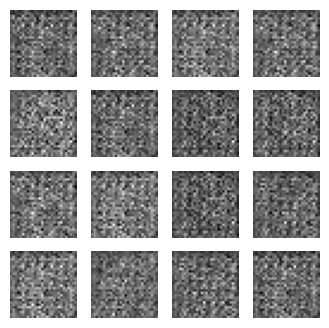

Epoch 1/10
Time for epoch 1: 9.61 seconds
Epoch 2/10
Time for epoch 2: 7.60 seconds
Epoch 3/10
Time for epoch 3: 7.44 seconds
Epoch 4/10
Time for epoch 4: 7.44 seconds
Epoch 5/10
Time for epoch 5: 7.53 seconds
Epoch 6/10
Time for epoch 6: 7.56 seconds
Epoch 7/10
Time for epoch 7: 7.44 seconds
Epoch 8/10
Time for epoch 8: 7.47 seconds
Epoch 9/10
Time for epoch 9: 7.49 seconds
Epoch 10/10
Time for epoch 10: 7.33 seconds


In [154]:
generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  print(f"Epoch {epoch}/{epochs}")
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()
  print(f"Time for epoch {epoch}: {end_time - start_time:.2f} seconds")

# Test set ELBO

In [155]:
for epoch in range(1):
    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
        loss(compute_loss(model, test_x))
    elbo = -loss.result()
    print('Test set ELBO: {:.4f}'.format(elbo.numpy()))

Test set ELBO: -180.2731


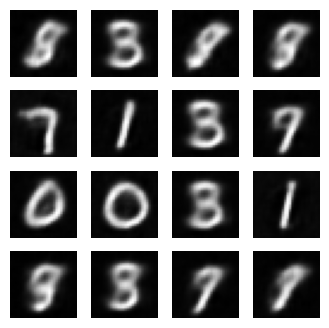

In [54]:
generate_and_save_images(model, 0, test_sample)